# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>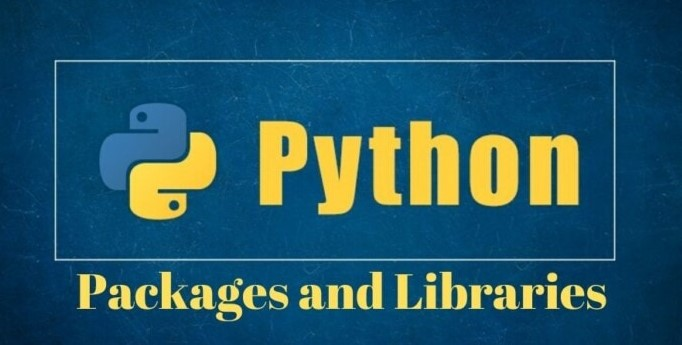

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy

In [ ]:
from function_utils import *

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>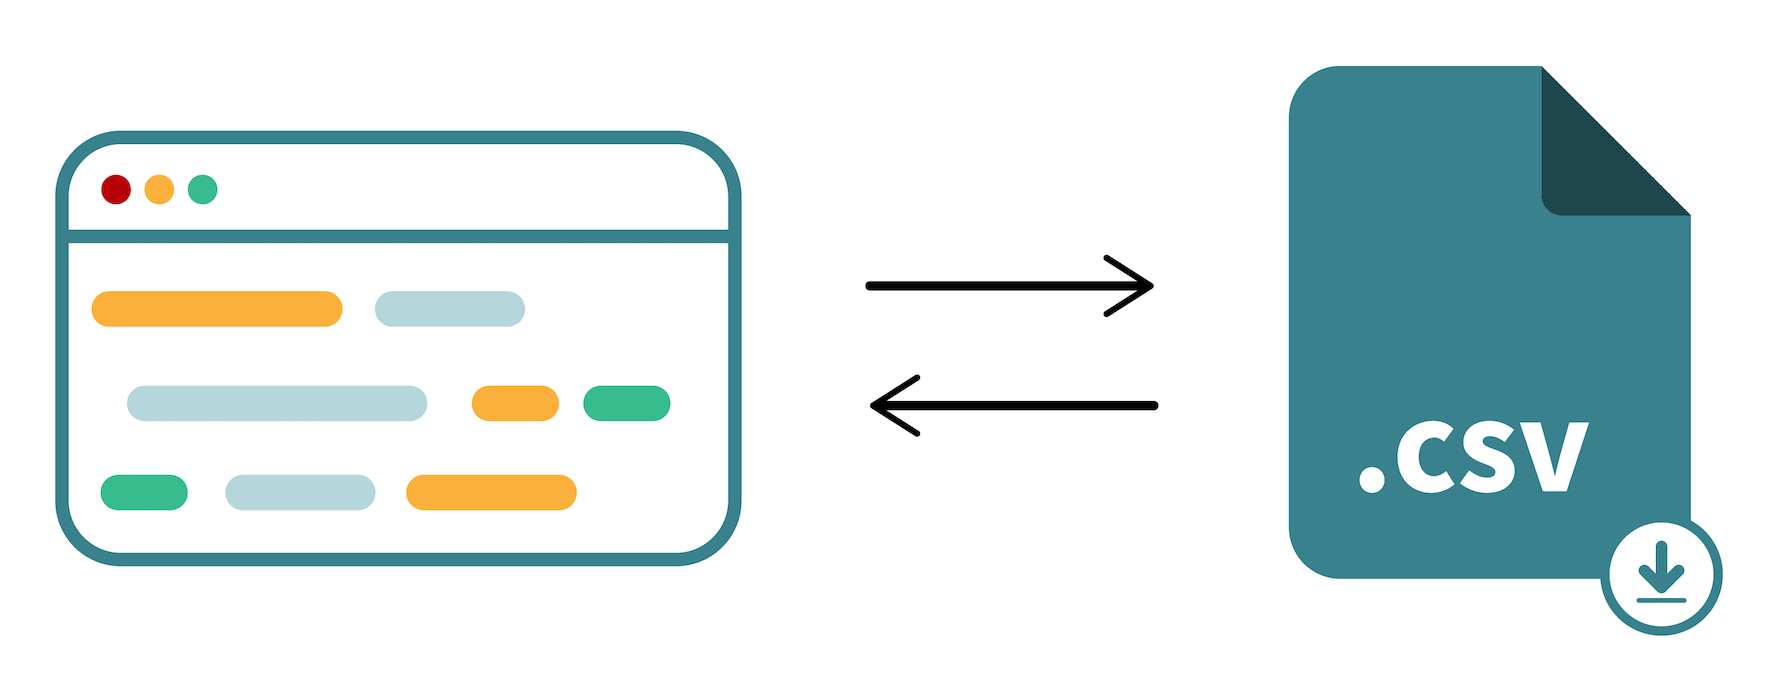

In [6]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [8]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [9]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [10]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [11]:
df.shape

(307507, 127)

</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>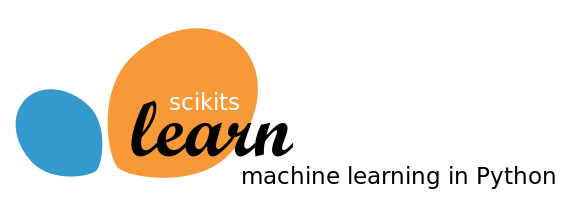

In [12]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate


# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>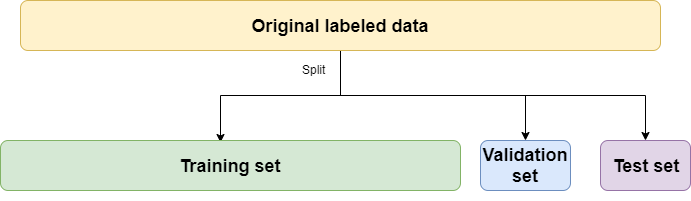

In [13]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 125 colonnes
Le dataset Test se compose de: 46126 lignes et 125 colonnes
Le dataset Validation se compose de: 46127 lignes et 125 colonnes


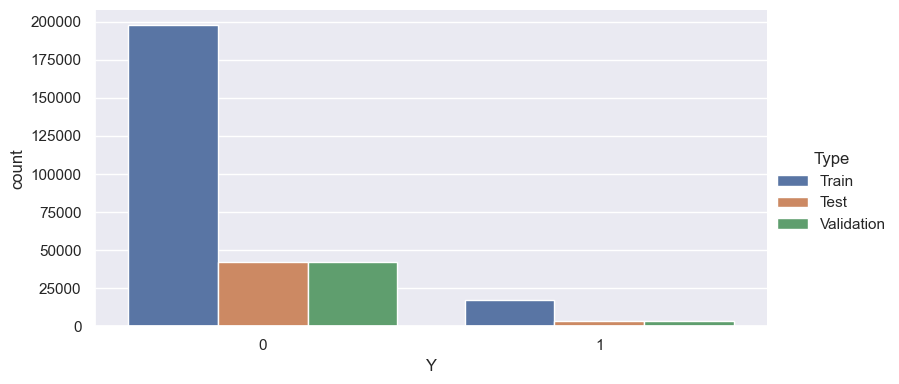

In [14]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [15]:
X_train.dtypes

NAME_CONTRACT_TYPE      object
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 125, dtype: object

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


</Br>

</Br>

</Br>

## <a name="C4"><font color='purple'>IV. Chargement des models</font></a>

In [55]:
from sklearn.model_selection import GridSearchCV
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import f1_score, roc_auc_score, roc_curve

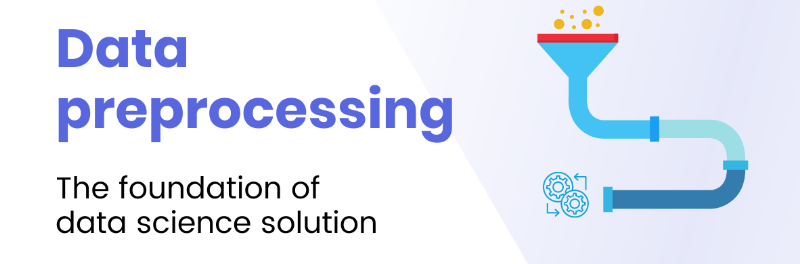

In [45]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")
joblib.dump(regLog_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")
joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")
joblib.dump(GradientBoosting_pipe,"data/modeles sauvegardés/GradientBoostingClassifier_model.sav")
joblib.dump(MLPC_pipe, "data/modeles sauvegardés/MultiLayerPerceptronClassifier_model.sav")

joblib.dump(KNeighbors_pipe,  "data/modeles sauvegardés/KNeighborsClassifier_model.sav")
joblib.dump(LDA_pipe, "data/modeles sauvegardés/DiscriminanteAnalysisLineaire_model.sav")
joblib.dump(PAC_pipe, "data/modeles sauvegardés/PassiveAggressiveClassifier_model.sav")
joblib.dump(Perceptron_pipe, "data/modeles sauvegardés/simplePerceptronClassifier_model.sav")

# Model de traitement des données
joblib.dump(intermediaire_pipeline, "data/modeles sauvegardés/intermediaire_pipeline.sav")


['data/modeles sauvegardés/intermediaire_pipeline.sav']

In [25]:
gc.collect()

0

In [26]:
import joblib
HistGB_pipe = joblib.load( "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
LGBM_pipe = joblib.load("data/modeles sauvegardés/lightGBMClasiifer_model.sav")

## <a name="C5"><font color='blue'>V. MLflow</font></a>

In [91]:
import mlflow
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss, roc_auc_score

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [ ]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

In [ ]:
#mlflow.set_tracking_uri("file:///Users/mah/mlruns")

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
mlflow.set_experiment('OC DS P7_Model Implémentez un modèle de scoring') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog()# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

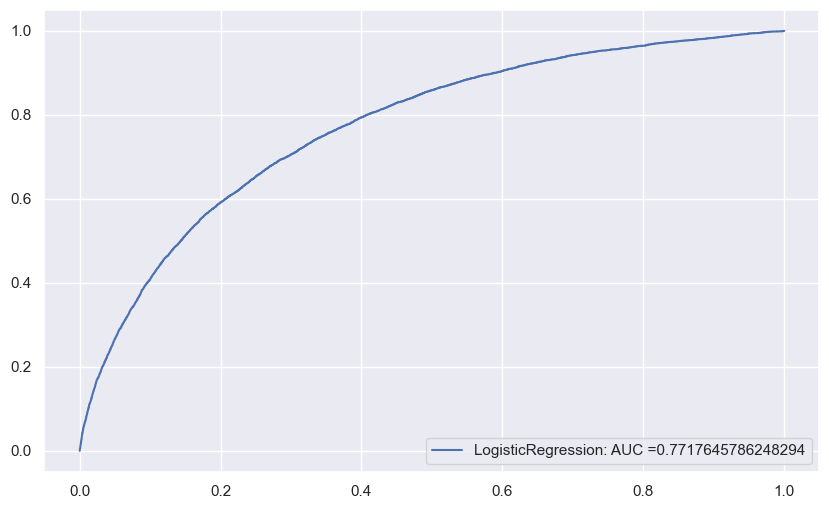

In [94]:
# premier run
with mlflow.start_run(run_name='Reg_logistic_defaut'):
    logisReg = LogisticRegression()
    logisReg.fit(X_train_processed,y_train)
    
    y_pred = logisReg.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy',acc)
    mlflow.log_metric('precision',prec)
    mlflow.log_metric('recall',recall)
    mlflow.log_metric('F1',f1)
    mlflow.log_metric('AUC',auc)
    mlflow.sklearn.log_model(logisReg, 'RegLogistic_defaut')
    generate_auc_roc_curve(logisReg,X_test_processed,y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

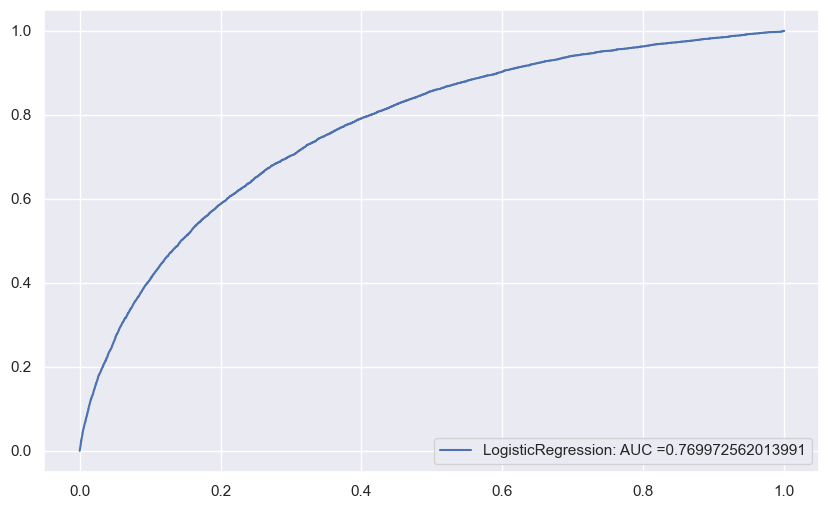

In [95]:
# deuxieme run
with mlflow.start_run(run_name='Reg_logistic_max_iter20000'):
    logisReg2 = LogisticRegression(max_iter = 20000)
    logisReg2.fit(X_train_processed,y_train)
    
    y_pred = logisReg2.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy_test',acc)
    mlflow.log_metric('precision_test',prec)
    mlflow.log_metric('recall_test',recall)
    mlflow.log_metric('F1_test',f1)
    mlflow.log_metric('AUC_test',auc)
    mlflow.sklearn.log_model(logisReg2, 'RegLogistic_max_iter20000')
    generate_auc_roc_curve(logisReg2,X_test_processed,y_test)

In [ ]:
# best param run
with mlflow.start_run(run_name='Reg_logistic_best_param'):
    logisReg = LogisticRegression()
    logisReg.fit(X_train_processed,y_train)
    
    y_pred = logisReg.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy_test',acc)
    mlflow.log_metric('precision_test',prec)
    mlflow.log_metric('recall_test',recall)
    mlflow.log_metric('F1_test',f1)
    mlflow.log_metric('AUC_test',auc)
    mlflow.sklearn.log_model(logisReg, 'RegLogistic_defaut')
    generate_auc_roc_curve(logisReg,X_test_processed,y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>